<a href="https://colab.research.google.com/github/rowanmacy/text-classifier/blob/main/Problem_2_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Import libraries
import pandas as pd
import numpy as np
import os
import textwrap

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from scipy.stats import uniform

In [ ]:
# TODOs

In [2]:
# Clone repo
!rm -rf /content/text-classifier  # clear any existing clone
!git clone "https://github.com/rowanmacy/text-classifier/"  # clone repo

Cloning into 'text-classifier'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 69 (delta 15), reused 30 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 31.50 MiB | 12.88 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
# Check repo contents
!ls /content/text-classifier/starter_code/data_readinglevel/

x_test_BERT_embeddings.npz  x_train_BERT_embeddings.npz  y_train.csv
x_test.csv		    x_train.csv


## Read in data

In [63]:
# Read in training data
x_dev = np.array(np.load("/content/text-classifier/starter_code/data_readinglevel/x_train_BERT_embeddings.npz")['arr_0'])
y_dev = pd.read_csv("/content/text-classifier/starter_code/data_readinglevel/y_train.csv")
x_test  = np.array(np.load("/content/text-classifier/starter_code/data_readinglevel/x_test_BERT_embeddings.npz")['arr_0'])

In [66]:
# Convert y_train_df into binary classification array
# Turn y_train data into binary classification
y_dev['Class'] = (y_dev['Coarse Label'] == 'Key Stage 4-5').astype(int)
y_dev = y_dev['Class']

## Pre-defined split for proxy test set (validation)

In [67]:
X_train, X_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=42, shuffle=True)

## Set up pipeline

In [68]:
# Define pipeline for preprocessing and classifier
problem_1_pipeline = Pipeline([
     ('problem_2_model', LogisticRegression(max_iter=500, random_state=101, penalty='l2')),
])

## Create RandomizedSearchCV

In [69]:
# Define hyperparameter grid to search and scoring metric
distributions = dict()

# Model parameters
distributions['problem_2_model__C'] = np.logspace(-6, 6, 1000)
distributions['problem_2_model__solver'] = ['lbfgs', 'saga', 'liblinear']
distributions['problem_2_model__penalty'] = ['l1', 'l2']

# Preprocessor parameters
scoring_metric = 'roc_auc'

In [70]:
# Define RandomizedSearchCV and fit to training data
random_searcher = RandomizedSearchCV(
    problem_1_pipeline,
    distributions,
    n_iter=100,  # increases number of parameter combinations tried
    scoring=scoring_metric,
    cv=KFold(n_splits=10, shuffle=True), # Always good to shuffle
    refit=True, # Automatically retrain the best-performing model on all available data
    verbose = 1,
    random_state=101,
    error_score = 'raise')

In [ ]:
# Fit random_searcher object to training data
random_searcher.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

In [ ]:
# Print result of search
problem_1_hyp_results = pd.DataFrame(random_searcher.cv_results_).copy()
param_keys = ['param_'+str(key) for key in random_searcher.best_params_.keys()]

# Rearrange row order
problem_1_hyp_results.sort_values(param_keys, inplace=True)

# Visualize
problem_1_hyp_results[param_keys + ['mean_test_score', 'rank_test_score']]

,param_problem_1_preprocessor__min_df,param_problem_1_preprocessor__max_features,param_problem_1_preprocessor__max_df,param_problem_1_model__C,mean_test_score,rank_test_score
25,0.010000,19064,0.652525,30.442722,0.694059,97
8,0.010303,16426,0.717172,288044.415340,0.695306,96
58,0.010303,16924,0.616162,0.167967,0.716294,14
24,0.010606,15331,0.810101,0.000008,0.699532,86
41,0.010606,15978,0.656566,286.059554,0.696718,93
...,...,...,...,...,...,...
73,0.038485,17969,0.858586,0.198288,0.713674,20
22,0.038788,17272,0.781818,178.752553,0.710942,38
39,0.039697,17820,0.830303,151.418933,0.710505,42
79,0.040000,15829,0.802020,23246.970600,0.710927,40


In [ ]:
# Capture best hyperparameters
problem_1_params = random_searcher.best_params_

for param, value in problem_1_params.items():
  print(param, ':', value)

problem_1_preprocessor__min_df : 0.022727272727272728
problem_1_preprocessor__max_features : 19363
problem_1_preprocessor__max_df : 0.7454545454545454
problem_1_model__C : 0.009203731996618222


## Make predictions and plot ROC curve

In [ ]:
# Evaluate performance on training and validation data
yhat_tr = random_searcher.predict_proba(X_train)[:,1]
yhat_val = random_searcher.predict_proba(X_val)[:,1]

# Calculate AUROC for training and validation predictions
roc_auc_tr = roc_auc_score(y_train, yhat_tr)
roc_auc_val = roc_auc_score(y_val, yhat_val)
print('Training score:', round(roc_auc_tr, 3))
print('Validation score:', round(roc_auc_val, 3))

Training score: 0.77
Validation score: 0.731


In [ ]:
# Print confusion matrices at 50% threshold
print('Training CF:\n', confusion_matrix(y_train, yhat_tr >= 0.5))
print('\nValidation CF:\n', confusion_matrix(y_val, yhat_val >= 0.5))

Training CF:
 [[1164  846]
 [ 497 1938]]

Validation CF:
 [[276 223]
 [145 468]]


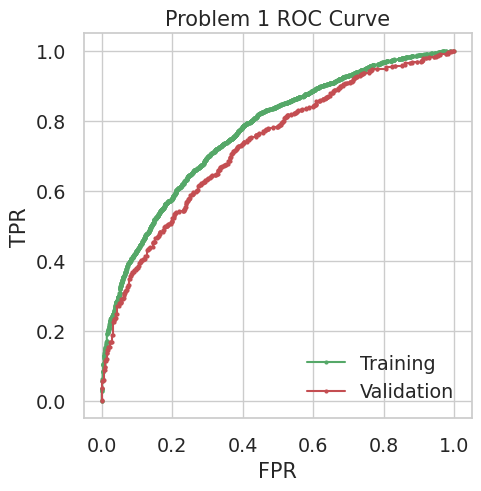

In [ ]:
# Print ROC curves
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train, yhat_tr)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, yhat_val)

plt.figure(figsize=(5,5))
plt.plot(tr_fpr, tr_tpr, 'g.-', label='Training')
plt.plot(val_fpr, val_tpr, 'r.-', label='Validation')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Problem 1 ROC Curve')
plt.legend(loc='lower right')

## Create graphic for hyperparameter selection of 'min_df'

In [ ]:
# Generate range of values for min_df and initialize AUROC score lists
min_df_range = np.linspace(0, 0.04, 20)
#C_range = np.logspace(-6, 3, 20)
tr_AUROC = []
val_AUROC = []

In [ ]:
# Loop through values of min_df and calculate training and validation scores
for frac in min_df_range:
  problem_1_hyp_pipeline = Pipeline([
    ('problem_1_preprocessor', CountVectorizer(lowercase=True, strip_accents='ascii', max_df=problem_1_params['problem_1_preprocessor__max_df'], max_features=problem_1_params['problem_1_preprocessor__max_features'], min_df=frac)),
    ('problem_1_model', LogisticRegression(max_iter=500, random_state=101, penalty='l2', C=problem_1_params['problem_1_model__C']))])

  # Fit to training data
  problem_1_hyp_pipeline.fit(X_train, y_train)

  # Predict on training and validation sets
  yhat_tr = problem_1_hyp_pipeline.predict_proba(X_train)[:,1]
  yhat_val = problem_1_hyp_pipeline.predict_proba(X_val)[:,1]

  # Calculate and append AUROC scores
  tr_AUROC.append(roc_auc_score(y_train, yhat_tr))
  val_AUROC.append(roc_auc_score(y_val, yhat_val))

  print(frac, ':', roc_auc_score(y_val, yhat_val))


0.0 : 0.7691892757783103
0.002105263157894737 : 0.7601532592101005
0.004210526315789474 : 0.7521633805947949
0.00631578947368421 : 0.7443533069401445
0.008421052631578947 : 0.740034718703312
0.010526315789473684 : 0.7392010775220915
0.01263157894736842 : 0.7391487706244463
0.014736842105263158 : 0.7364255427657925
0.016842105263157894 : 0.735104793600251
0.01894736842105263 : 0.7335682784819231
0.021052631578947368 : 0.7311392769225238
0.023157894736842106 : 0.7304233262610049
0.02526315789473684 : 0.7307142833791564
0.027368421052631577 : 0.7283833572528416
0.029473684210526315 : 0.7283866264339446
0.031578947368421054 : 0.728455279237104
0.03368421052631579 : 0.7266768447171668
0.035789473684210524 : 0.7275627927960324
0.03789473684210526 : 0.7267683817880459
0.04 : 0.7221490288897534


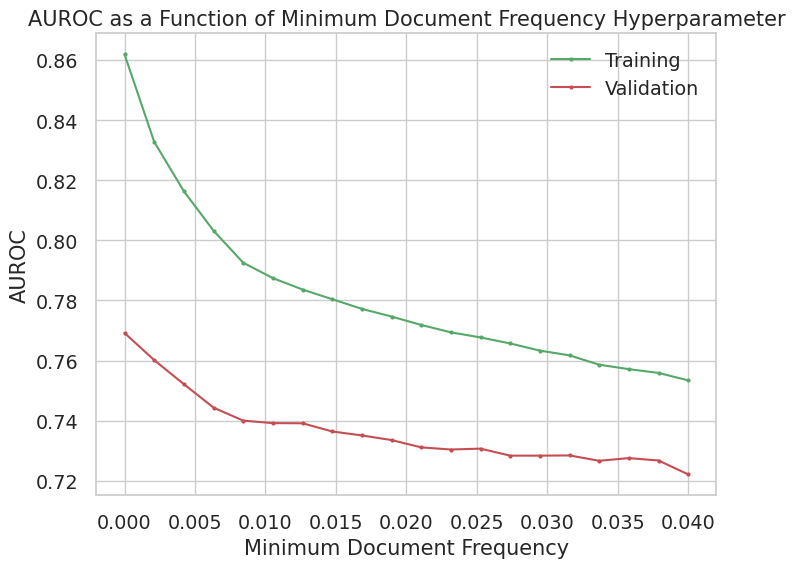

In [ ]:
# Plot training and validation AUROC vs. value of min_df
plt.figure(figsize=(8,6))
plt.plot(min_df_range, tr_AUROC, 'g.-', label='Training')
plt.plot(min_df_range, val_AUROC, 'r.-', label='Validation')
plt.xlabel('Minimum Document Frequency')
plt.ylabel('AUROC')
plt.title('AUROC as a Function of Minimum Document Frequency Hyperparameter')
plt.legend()

## Save results to files

In [ ]:
#file = open('parameter_iterations.txt', 'x')

In [ ]:
# Save parameters to text file
with open('parameter_iterations.txt', "a") as f:
  for param, value in problem_1_params.items():
    f.write('\n' + str(param) + ': ' + str(value))
  f.write('\n\nTraining score: ' + str(round(roc_auc_tr, 3)))
  f.write('\n\n')

In [ ]:
# Make predictions on test data
yhat_te = random_searcher.predict_proba(te_text_list)[:,1]

In [ ]:
# Delete previous file
os.remove('yproba1_test.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'yproba1_test.txt'

In [ ]:
# Save results to .txt file
file = open('yproba1_test.txt', "x")

with open('yproba1_test.txt', "w") as f:
    f.write('\n'.join(yhat_te.astype('str')))

## ARCHIVE

In [ ]:
# Create CountVectorizer object
# TODO: min_df, max_df, binary
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(tr_text_list)
vectorizer.get_feature_names_out()
vocab_list = vectorizer.vocabulary_

In [ ]:
# Fit logistic regression model to training data
clf.fit(X_train, y_train)

In [ ]:
# Convert test data into vector
X_test_list = x_test_df['text'].values.tolist()
V = len(x_test_df)

In [ ]:
# Make predictions on test vector
yhat_test = []

for passage in X_test_list:
  x_V = vectorizer.transform([passage])
  #print(x_V.shape)
  prediction = clf.predict_proba(x_V.reshape((1,26866)))

  with open('yproba1_test.txt', 'a') as f:
    f.write(prediction[0][1].astype('str')+'\n')

  print('Prediction:', prediction[0][1])


In [ ]:
# Cross-validate
# Hyperparameter values
C_grid = np.logspace(-4, 4, 17)
k_grid = range(1, 18)

# Create development dataset

# Split data for CV
SEED = 12345

# Use K-fold to perform cross-validation
K = 10
kf = sklearn.model_selection.KFold(n_splits=K, shuffle=True, random_state=SEED)

# Train models with desired degree, alpha, K-fold
for c_ind, c in enumerate(C_grid):
        for k, (train_ind, val_ind) in enumerate(kf.split(X_train, y_train)):
            #print(f"fold {k}")
            model = sklearn.Pipeline([
                # TODO: call pipeline defined earlier
                ])
            #print(f"model defined")
            # Train the model
            model.fit(X_train[train_ind], y_train[train_ind])

            # Make predictions on validation data
            yhat_L = model.predict(X_train[val_ind])  #removed sanitize step since it's not defined in this notebook

            print(f"C {c}, K {k}, AUCROC")
            # TODO: compute AUCROC


In [ ]:
# Define preprocessor
def build_preprocessor():
  preprocessor = Pipeline([
      ('vectorizer', CountVectorizer(
       lowercase=True  # make everything lowercase
       #strip_accents='ascii',
       #stop_words='english'  # remove stop words
      ))
  ])
  return preprocessor

# Process data
preprocessor = build_preprocessor()
x_train_processed = preprocessor.fit_transform(x_train_df['text'])
max_features_total = x_train_processed.shape[1]